In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/affectnet-yolo-format


Found 18952 images belonging to 6 classes.
Found 4742 images belonging to 6 classes.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 112s 164ms/step - accuracy: 0.1957 - loss: 2.3448 - val_accuracy: 0.2619 - val_loss: 1.7162 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - accuracy: 0.2458 - loss: 1.7744 - val_accuracy: 0.3026 - val_loss: 1.7179 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.3374 - loss: 1.5568 - val_accuracy: 0.2741 - val_loss: 2.2000 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accuracy: 0.4039 - loss: 1.4103 - val_accuracy: 0.4026 - val_loss: 1.5670 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - accuracy: 0.4668 - loss: 1.3006 - val_accuracy: 0.3882 - val_loss: 1.6760 - learning_rate: 0.0010
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - accuracy: 0.5180 - loss: 1.1893 - val_accuracy: 0.5985 - val_loss: 0.9882 - learning_rate: 0.0010
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accuracy: 0.5525 - loss

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

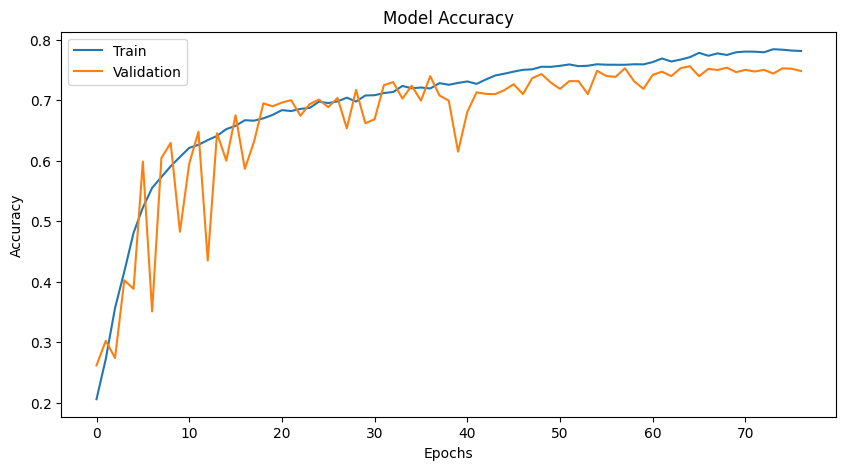

149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step


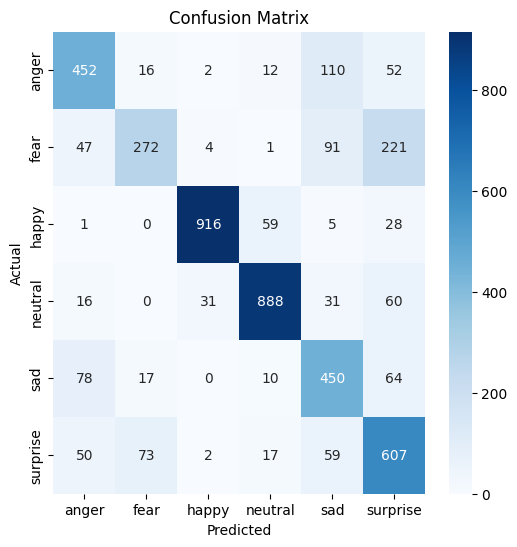

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix

# Define paths to AffectNet dataset
DATASET_PATH = "/kaggle/input/affectnet/split_dataset"  # Update if needed
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Emotion labels mapping
emotion_label_to_text = {
    "anger": 0, "disgust": 1, "fear": 2, "happy": 3, 
    "neutral": 4, "sad": 5, "surprise": 6
}

# Interested emotions (excluding disgust)
INTERESTED_LABELS = ["anger", "fear", "happy", "neutral", "sad", "surprise"]

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(96, 96),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(96, 96),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS,
    shuffle=False
)

# Define CNN model
def build_net(optimizer):
    model = Sequential()

    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal', input_shape=(96, 96, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(len(INTERESTED_LABELS), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_affectnet_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
callbacks = [early_stopping, lr_scheduler, model_checkpoint]

# Model Training
batch_size = 32
epochs = 100
optimizer = optimizers.Adam(learning_rate=0.001)
model = build_net(optimizer)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=callbacks
)

# Save the final model
model.save("final_affectnet_emotion_model.keras")

# Plot Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=INTERESTED_LABELS, 
            yticklabels=INTERESTED_LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Found 18952 images belonging to 6 classes.
Found 4742 images belonging to 6 classes.
Class Weights: {0: 1.2271432271432272, 1: 1.2435695538057743, 2: 0.7828170177612557, 3: 0.7704065040650406, 4: 1.2777777777777777, 5: 0.9776127102032395}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,307,750 (20.25 MB)

 Trainable params: 5,305,766 (20.24 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 92ms/step - accuracy: 0.1786 - loss: 2.6277 - val_accuracy: 0.2060 - val_loss: 1.7861 - learning_rate: 5.0000e-04
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - accuracy: 0.1977 - loss: 2.0583 - val_accuracy: 0.1712 - val_loss: 1.9204 - learning_rate: 5.0000e-04
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - accuracy: 0.2287 - loss: 1.8637 - val_accuracy: 0.2102 - val_loss: 1.9082 - learning_rate: 5.0000e-04
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.2807 - loss: 1.7322 - val_accuracy: 0.2157 - val_loss: 2.1569 - learning_rate: 5.0000e-04
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - accuracy: 0.3593 - loss: 1.5951 - val_accuracy: 0.3889 - val_loss: 1.5928 - learning_rate: 5.0000e-04
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - accuracy: 0.4198 - loss: 1.4939 - val_accuracy: 0.3775 - val_loss: 1.7532 - learning_rate: 5.0000e-04
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - a

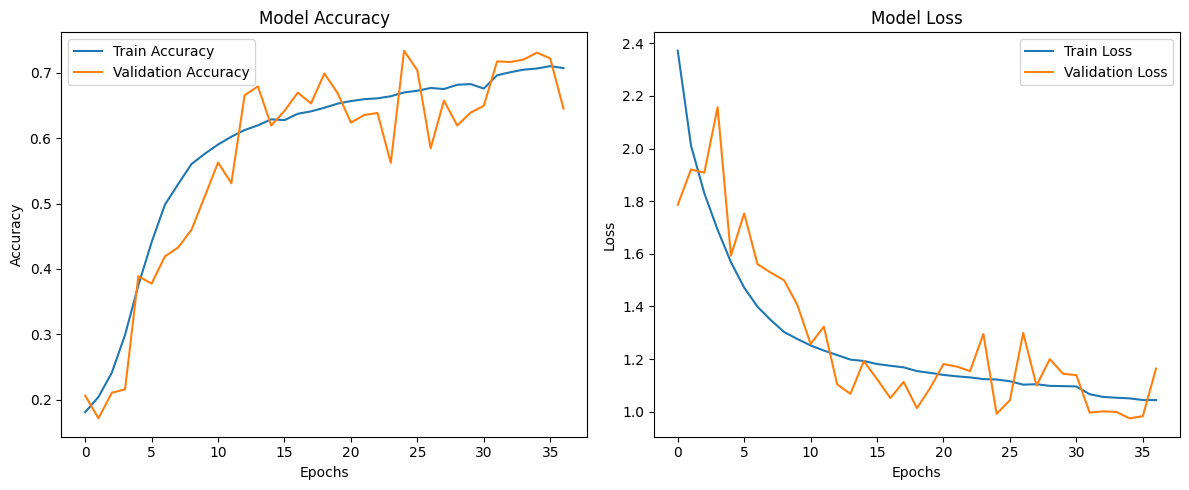

149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step


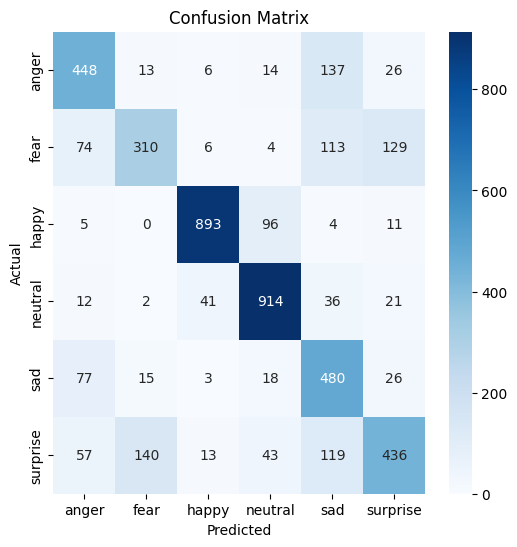

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# ---------------------------
# Dataset Paths & Parameters
# ---------------------------
DATASET_PATH ="/kaggle/input/affectnet/split_dataset"  # Adjust if necessary
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Interested classes (excluding 'disgust')
INTERESTED_CLASSES = ['anger', 'fear', 'happy', 'neutral', 'sad', 'surprise']
IMG_SIZE = (96,96)
BATCH_SIZE = 32
COLOR_MODE = "grayscale"  # AffectNet images are typically grayscale for FER tasks

# ---------------------------
# Data Augmentation & Generators
# ---------------------------
# Augmentation for training: includes brightness adjustments to help differentiate similar classes.
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.5, 1.5],
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# For validation/testing, we only rescale.
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Training generator using the specified classes
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    classes=INTERESTED_CLASSES,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Validation generator
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    classes=INTERESTED_CLASSES,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# ---------------------------
# Compute Class Weights
# ---------------------------
# Using the training generator to compute weights for each class (helps if some classes are underrepresented)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# ---------------------------
# Build Improved CNN Model
# ---------------------------
def create_improved_model(input_shape=(96,96, 1), num_classes=len(INTERESTED_CLASSES)):
    model = keras.Sequential()
    
    # Block 1
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    
    # Block 2
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    # Block 3
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.35))
    
    # Block 4
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    
    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

model = create_improved_model()
model.summary()

# ---------------------------
# Compile Model with Improvements
# ---------------------------
# Adam optimizer with tuned learning rate and label smoothing to avoid overconfidence.
optimizer = optimizers.Adam(learning_rate=0.0005)
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# ---------------------------
# Setup Callbacks
# ---------------------------
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-6)
model_checkpoint = callbacks.ModelCheckpoint("best_improved_affectnet_model.keras", monitor='val_accuracy', save_best_only=True)

# ---------------------------
# Train the Model
# ---------------------------
EPOCHS = 100
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)

# Save the final model
model.save("affectnet_model2.keras")

# ---------------------------
# Plot Training History
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------
# Evaluate: Confusion Matrix
# ---------------------------
# Calculate predictions for the validation set
val_steps = validation_generator.n // validation_generator.batch_size
if validation_generator.n % validation_generator.batch_size != 0:
    val_steps += 1
predictions = model.predict(validation_generator, steps=val_steps)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=INTERESTED_CLASSES, yticklabels=INTERESTED_CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# ---------------------------
# Dataset Paths & Parameters
# ---------------------------
DATASET_PATH ="/kaggle/input/affectnet/split_dataset"  # Adjust if necessary
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Interested classes (excluding 'disgust')
INTERESTED_CLASSES = ['anger', 'fear', 'happy', 'neutral', 'sad', 'surprise']
IMG_SIZE = (96,96)
BATCH_SIZE = 32
COLOR_MODE = "grayscale"  # AffectNet images are typically grayscale for FER tasks

# ---------------------------
# Data Augmentation & Generators
# ---------------------------
# Augmentation for training: includes brightness adjustments to help differentiate similar classes.
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.5, 1.5],
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# For validation/testing, we only rescale.
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Training generator using the specified classes
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    classes=INTERESTED_CLASSES,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Validation generator
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    classes=INTERESTED_CLASSES,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# ---------------------------
# Compute Class Weights
# ---------------------------
# Using the training generator to compute weights for each class (helps if some classes are underrepresented)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# ---------------------------
# Build Improved CNN Model
# ---------------------------
def create_improved_model(input_shape=(96,96, 1), num_classes=len(INTERESTED_CLASSES)):
    model = keras.Sequential()
    
    # Block 1
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    
    # Block 2
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    # Block 3
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.35))
    
    # Block 4
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    
    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

model = create_improved_model()
model.summary()

# ---------------------------
# Compile Model with Improvements
# ---------------------------
# Adam optimizer with tuned learning rate and label smoothing to avoid overconfidence.
optimizer = optimizers.Adam(learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# ---------------------------
# Setup Callbacks
# ---------------------------
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-6)
model_checkpoint = callbacks.ModelCheckpoint("best_improved_affectnet_model.keras", monitor='val_accuracy', save_best_only=True)

# ---------------------------
# Train the Model
# ---------------------------
EPOCHS = 100
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)

# Save the final model
model.save("affectnet_model3.keras")

# ---------------------------
# Plot Training History
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------
# Evaluate: Confusion Matrix
# ---------------------------
# Calculate predictions for the validation set
val_steps = validation_generator.n // validation_generator.batch_size
if validation_generator.n % validation_generator.batch_size != 0:
    val_steps += 1
predictions = model.predict(validation_generator, steps=val_steps)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=INTERESTED_CLASSES, yticklabels=INTERESTED_CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Found 18952 images belonging to 6 classes.
Found 4742 images belonging to 6 classes.
Class Weights: {0: 1.2271432271432272, 1: 1.2435695538057743, 2: 0.7828170177612557, 3: 0.7704065040650406, 4: 1.2777777777777777, 5: 0.9776127102032395}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,307,750 (20.25 MB)

 Trainable params: 5,305,766 (20.24 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 116s 174ms/step - accuracy: 0.1801 - loss: 2.5025 - val_accuracy: 0.1875 - val_loss: 1.7851 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.1945 - loss: 1.9144 - val_accuracy: 0.2351 - val_loss: 1.7788 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 49s 81ms/step - accuracy: 0.2483 - loss: 1.7795 - val_accuracy: 0.2554 - val_loss: 1.8949 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.3339 - loss: 1.6360 - val_accuracy: 0.2050 - val_loss: 2.4211 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 54s 90ms/step - accuracy: 0.4256 - loss: 1.5052 - val_accuracy: 0.4831 - val_loss: 1.3626 - learning_rate: 0.0010
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - accuracy: 0.4826 - loss: 1.4359 - val_accuracy: 0.4262 - val_loss: 1.5578 - learning_rate: 0.0010
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.5130 - loss

Found 20933 images belonging to 7 classes.
Found 5238 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


655/655 ━━━━━━━━━━━━━━━━━━━━ 71s 93ms/step - accuracy: 0.1732 - loss: 2.3943 - val_accuracy: 0.2528 - val_loss: 1.8638 - learning_rate: 0.0010
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 54s 81ms/step - accuracy: 0.2404 - loss: 1.8862 - val_accuracy: 0.3431 - val_loss: 1.6620 - learning_rate: 0.0010
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - accuracy: 0.3172 - loss: 1.6955 - val_accuracy: 0.4137 - val_loss: 1.5129 - learning_rate: 0.0010
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 54s 81ms/step - accuracy: 0.4137 - loss: 1.4976 - val_accuracy: 0.3721 - val_loss: 1.7023 - learning_rate: 0.0010
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 54s 81ms/step - accuracy: 0.4501 - loss: 1.3987 - val_accuracy: 0.4712 - val_loss: 1.3224 - learning_rate: 0.0010
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.4933 - loss: 1.2804 - val_accuracy: 0.5193 - val_loss: 1.2206 - learning_rate: 0.0010
Epoch 7/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - accuracy: 0.5127 - loss: 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

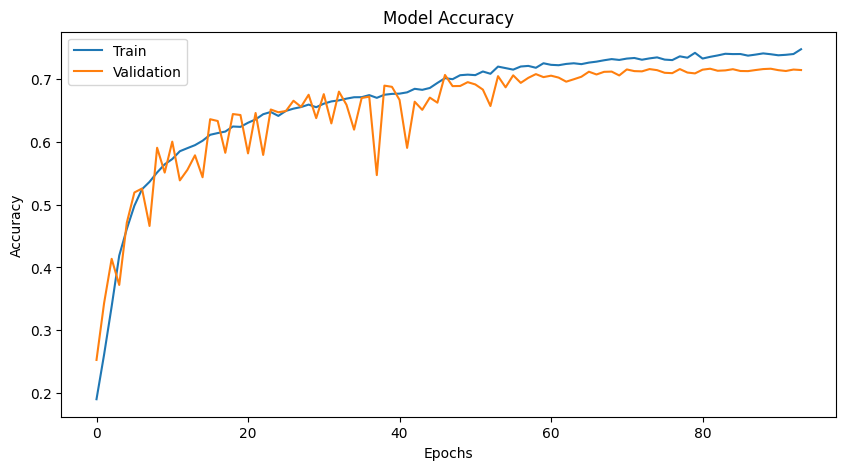

164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step


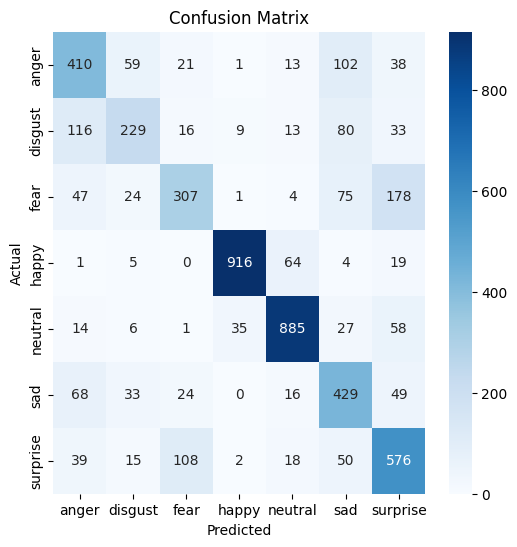

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix

# Define paths to AffectNet dataset
DATASET_PATH = "/kaggle/input/affectnet/split_dataset"  # Update if needed
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Emotion labels mapping
emotion_label_to_text = {
    "anger": 0, "disgust": 1, "fear": 2, "happy": 3, 
    "neutral": 4, "sad": 5, "surprise": 6
}

# Interested emotions (excluding disgust)
INTERESTED_LABELS = ["anger", "disgust","fear", "happy", "neutral", "sad", "surprise"]

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(96, 96),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(96, 96),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS,
    shuffle=False
)

# Define CNN model
def build_net(optimizer):
    model = Sequential()

    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal', input_shape=(96, 96, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(len(INTERESTED_LABELS), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_affectnet_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
callbacks = [early_stopping, lr_scheduler, model_checkpoint]

# Model Training
batch_size = 32
epochs = 100
optimizer = optimizers.Adam(learning_rate=0.001)
model = build_net(optimizer)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=callbacks
)

# Save the final model
model.save("affectnet_emotion_model_final.keras")

# Plot Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=INTERESTED_LABELS, 
            yticklabels=INTERESTED_LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Found 20933 images belonging to 7 classes.
Found 5238 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


655/655 ━━━━━━━━━━━━━━━━━━━━ 134s 181ms/step - accuracy: 0.1590 - loss: 2.6793 - val_accuracy: 0.2006 - val_loss: 1.9521 - learning_rate: 5.0000e-04
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 60s 91ms/step - accuracy: 0.1739 - loss: 2.1246 - val_accuracy: 0.1959 - val_loss: 1.9246 - learning_rate: 5.0000e-04
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 61s 92ms/step - accuracy: 0.2015 - loss: 1.9563 - val_accuracy: 0.2444 - val_loss: 1.7986 - learning_rate: 5.0000e-04
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 61s 92ms/step - accuracy: 0.2393 - loss: 1.8487 - val_accuracy: 0.2507 - val_loss: 1.8300 - learning_rate: 5.0000e-04
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 61s 92ms/step - accuracy: 0.2644 - loss: 1.7756 - val_accuracy: 0.1590 - val_loss: 2.8855 - learning_rate: 5.0000e-04
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 62s 93ms/step - accuracy: 0.2777 - loss: 1.7162 - val_accuracy: 0.3225 - val_loss: 1.5764 - learning_rate: 5.0000e-04
Epoch 7/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 61s 92ms/step -

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

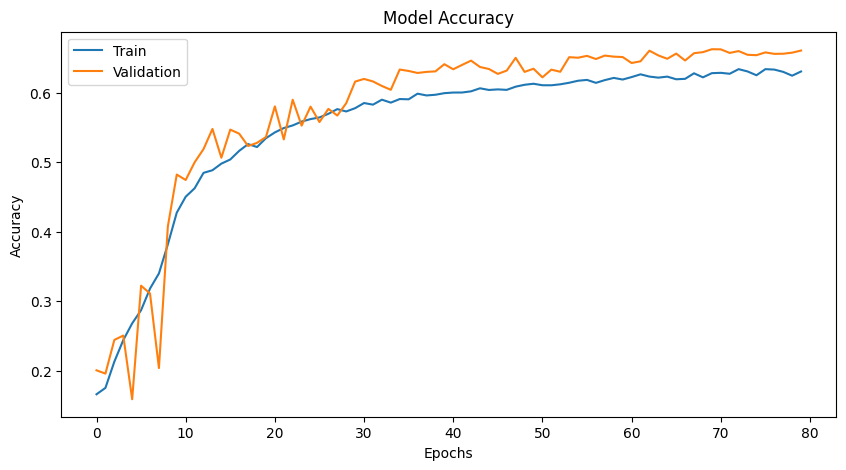

164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step


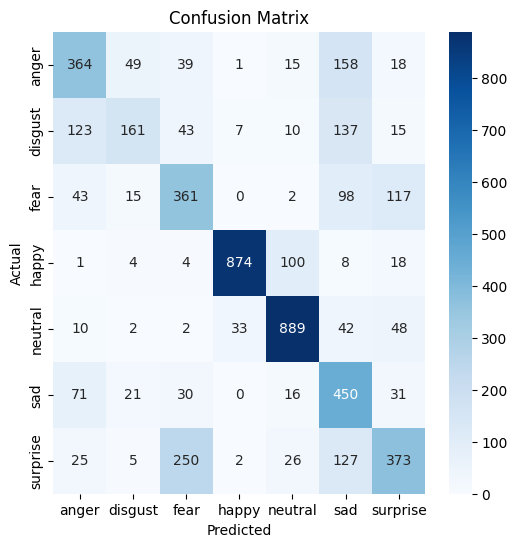

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix

# Define paths to AffectNet dataset
DATASET_PATH = "/kaggle/input/affectnet/split_dataset"
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Emotion labels mapping
emotion_label_to_text = {
    "anger": 0, "disgust": 1, "fear": 2, "happy": 3, 
    "neutral": 4, "sad": 5, "surprise": 6
}

# Interested emotions (excluding disgust)
INTERESTED_LABELS = ["anger", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Data Augmentation with brightness adjustment
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(96, 96),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(96, 96),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS,
    shuffle=False
)

# Define Enhanced CNN model
def build_net(optimizer):
    model = Sequential()

    model.add(Conv2D(64, (3,3), activation='elu', padding='same', kernel_initializer='he_normal', input_shape=(96, 96, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(256, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(len(INTERESTED_LABELS), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_affectnet_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
callbacks = [early_stopping, lr_scheduler, model_checkpoint]

# Model Training
batch_size = 32
epochs = 100
optimizer = optimizers.Adam(learning_rate=0.0005)  # Adjusted learning rate
model = build_net(optimizer)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=callbacks
)

# Save the final model
model.save("final_affectnet_emotion_model.keras")

# Plot Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=INTERESTED_LABELS, 
            yticklabels=INTERESTED_LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix

# Define paths to AffectNet dataset
DATASET_PATH = "/kaggle/input/affectnet/split_dataset"  # Update if needed
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Emotion labels mapping
emotion_label_to_text = {
    "anger": 0, "disgust": 1, "fear": 2, "happy": 3, 
    "neutral": 4, "sad": 5, "surprise": 6
}

# Interested emotions (excluding disgust)
INTERESTED_LABELS = ["anger", "disgust","fear", "happy", "neutral", "sad", "surprise"]

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(96, 96),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(96, 96),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS,
    shuffle=False
)

# Define CNN model
def build_net(optimizer):
    model = Sequential()

    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal', input_shape=(96, 96, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(len(INTERESTED_LABELS), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_affectnet_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
callbacks = [early_stopping, lr_scheduler, model_checkpoint]

# Model Training
batch_size = 32
epochs = 100
optimizer = optimizers.Adam(learning_rate=0.05)
model = build_net(optimizer)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=callbacks
)

# Save the final model
model.save("final_affectnet_emotion_model3.keras")

# Plot Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=INTERESTED_LABELS, 
            yticklabels=INTERESTED_LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Found 20933 images belonging to 7 classes.
Found 5238 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


655/655 ━━━━━━━━━━━━━━━━━━━━ 80s 101ms/step - accuracy: 0.1719 - loss: 2.2715 - val_accuracy: 0.2035 - val_loss: 1.9544 - learning_rate: 0.0500
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.1719 - loss: 2.0594 - val_accuracy: 0.1537 - val_loss: 2.0659 - learning_rate: 0.0500
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 53s 79ms/step - accuracy: 0.1749 - loss: 2.0471 - val_accuracy: 0.2022 - val_loss: 1.9969 - learning_rate: 0.0500
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - accuracy: 0.1773 - loss: 2.0533 - val_accuracy: 0.1205 - val_loss: 2.7305 - learning_rate: 0.0500
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - accuracy: 0.1726 - loss: 2.0370 - val_accuracy: 0.1670 - val_loss: 2.7905 - learning_rate: 0.0500
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - accuracy: 0.1723 - loss: 2.0286 - val_accuracy: 0.1951 - val_loss: 1.9780 - learning_rate: 0.0500
Epoch 7/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 54s 81ms/step - accuracy: 0.1808 - loss: